# 正規分布と混合正規分布のKL情報量のプロット

* 黒木玄
* 作成: 2018-04-10
* 更新: 2025-10-05 (Julia v0.6のコードをv1.0以上で動くように変更した)
* [Google Colabで実行](https://colab.research.google.com/github/genkuroki/public/blob/main/0055/%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83%E3%81%A8%E6%B7%B7%E5%90%88%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83%E3%81%AEKL%E6%83%85%E5%A0%B1%E9%87%8F%E3%81%AE%E3%83%97%E3%83%AD%E3%83%83%E3%83%88.ipynb?hl=ja)

次の形の1次元混合正規分布 $Q(a,b)$ を考える:

$$
q(x|a,b,c) = a\, p_N(x|0,1) + (1-a)\, p_N(x|b,c).
$$

ここで $p_N(x|\mu,\sigma)$ は正規分布の密度函数である.  $c=1, 1/2$ を固定して, $a,b$ を適当に動かしながら, Kullback-Leibler情報量 

$$
\mathrm{KL}\left(\mathrm{Normal}(\mu,\sigma)||Q(a,b)\right) = 
\int_{-\infty}^\infty p_N(x|\mu,\sigma)\log\frac{p_N(x|\mu,\sigma)}{q(x|a,b,c)}\,dx
$$

を最小化する $(\mu,\sigma)$ を求めてプロットする.  $(\mu,\sigma)$ は $(a,b)$ について不連続に変化する.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#荒いプロット" data-toc-modified-id="荒いプロット-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>荒いプロット</a></span><ul class="toc-item"><li><span><a href="#左右の山の分散がともに1の場合" data-toc-modified-id="左右の山の分散がともに1の場合-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>左右の山の分散がともに1の場合</a></span></li><li><span><a href="#左の山の分散が1で右の山の分散が0.5^2の場合" data-toc-modified-id="左の山の分散が1で右の山の分散が0.5^2の場合-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>左の山の分散が1で右の山の分散が0.5^2の場合</a></span></li></ul></li><li><span><a href="#倍の細かさでプロット" data-toc-modified-id="倍の細かさでプロット-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>倍の細かさでプロット</a></span></li><li><span><a href="#データの保存" data-toc-modified-id="データの保存-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>データの保存</a></span></li><li><span><a href="#解説" data-toc-modified-id="解説-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>解説</a></span></li></ul></div>

In [1]:
# Google Colabと自分のパソコンの両方で使えるようにするための工夫

using Pkg

"""すでにPkg.add済みのパッケージのリスト"""
_packages_added = [sort!(readdir(Sys.STDLIB));
    sort!([info.name for (uuid, info) in Pkg.dependencies() if info.is_direct_dep])]

"""_packages_added内にないパッケージをPkg.addする"""
add_pkg_if_not_added_yet(pkg) = if isnothing(Base.find_package(pkg))
    println(stderr, "# $(pkg).jl is not added yet, so let's add it.")
    Pkg.add(pkg)
end

"""expr::Exprからusing内の`.`を含まないモジュール名を抽出"""
function find_using_pkgs(expr::Expr)
    pkgs = String[]
    function traverse(expr::Expr)
        if expr.head == :using
            for arg in expr.args
                if arg.head == :. && length(arg.args) == 1
                    push!(pkgs, string(arg.args[1]))
                elseif arg.head == :(:) && length(arg.args[1].args) == 1
                    push!(pkgs, string(arg.args[1].args[1]))
                end
            end
        else
            for arg in expr.args arg isa Expr && traverse(arg) end
        end
    end
    traverse(expr)
    pkgs
end

"""必要そうなPkg.addを追加するマクロ"""
macro autoadd(expr)
    pkgs = find_using_pkgs(expr)
    :(add_pkg_if_not_added_yet.($(pkgs)); $expr)
end

@autoadd

In [2]:
@autoadd begin
using Distributions
using QuadGK
using Plots
default(fmt=:png, legend=false)
end

safemult(x,y) = ifelse(iszero(x), zero(x*y), x*y)
KullbackLeibler(P,Q) = quadgk(x->safemult(pdf(P,x), logpdf(P,x) - logpdf(Q,x)), -20, 20)[1]
#KullbackLeibler(P,Q) = quadgk(x->safemult(pdf(P,x), logpdf(P,x) - logpdf(Q,x)), -20, 20, reltol=1e-4)[1]
#KullbackLeibler(P,Q) = quadgk(x->safemult(pdf(P,x), logpdf(P,x) - logpdf(Q,x)), -20, 20, reltol=1e-5)[1]

function simKL(;
        as = 0.05:0.05:0.95,
        bs = 1.0:0.25:7.0,
        c = 1.0,
        μs = -1.5:0.5:8.5,
        σs = 0.2:0.2:4.0,
    )
    @show La = length(as)
    @show Lb = length(bs)
    @show Lμ = length(μs)
    @show Lσ = length(σs)
    
    kl = zeros(La,Lb,Lμ,Lσ)
    f(a, b, μ, σ) = KullbackLeibler(Normal(μ,σ), MixtureModel([Normal(0.0,1.0), Normal(b,c)], [a, 1-a]))
    for i in 1:La
        for j in 1:Lb
            print("($i,$j)")
            kl[i,j,:,:] .= f.(as[i], bs[j], μs, σs')
        end
    end
    
    fm(i,j) = findmin(@view kl[i,j,:,:])
    mc = minimizer_coordinate = [fm(i,j)[2] for i in 1:La, j in 1:Lb]
    minimizer_μ = [μs[mc[i,j][1]] for i in 1:La, j in 1:Lb]
    minimizer_σ = [σs[mc[i,j][2]] for i in 1:La, j in 1:Lb]
    minval = [fm(i,j)[1] for i in 1:La, j in 1:Lb]
    
    as, bs, c, μs, σs, kl, minimizer_coordinate, minimizer_μ, minimizer_σ, minval
end

simKL (generic function with 1 method)

## 荒いプロット

### 左右の山の分散がともに1の場合

La = length(as) = 19
Lb = length(bs) = 25
Lμ = length(μs) = 21
Lσ = length(σs) = 20
(1,1)(1,2)(1,3)(1,4)(1,5)(1,6)(1,7)(1,8)(1,9)(1,10)(1,11)(1,12)(1,13)(1,14)(1,15)(1,16)(1,17)(1,18)(1,19)(1,20)(1,21)(1,22)(1,23)(1,24)(1,25)(2,1)(2,2)(2,3)(2,4)(2,5)(2,6)(2,7)(2,8)(2,9)(2,10)(2,11)(2,12)(2,13)(2,14)(2,15)(2,16)(2,17)(2,18)(2,19)(2,20)(2,21)(2,22)(2,23)(2,24)(2,25)(3,1)(3,2)(3,3)(3,4)(3,5)(3,6)(3,7)(3,8)(3,9)(3,10)(3,11)(3,12)(3,13)(3,14)(3,15)(3,16)(3,17)(3,18)(3,19)(3,20)(3,21)(3,22)(3,23)(3,24)(3,25)(4,1)(4,2)(4,3)(4,4)(4,5)(4,6)(4,7)(4,8)(4,9)(4,10)(4,11)(4,12)(4,13)(4,14)(4,15)(4,16)(4,17)(4,18)(4,19)(4,20)(4,21)(4,22)(4,23)(4,24)(4,25)(5,1)(5,2)(5,3)(5,4)(5,5)(5,6)(5,7)(5,8)(5,9)(5,10)(5,11)(5,12)(5,13)(5,14)(5,15)(5,16)(5,17)(5,18)(5,19)(5,20)(5,21)(5,22)(5,23)(5,24)(5,25)(6,1)(6,2)(6,3)(6,4)(6,5)(6,6)(6,7)(6,8)(6,9)(6,10)(6,11)(6,12)(6,13)(6,14)(6,15)(6,16)(6,17)(6,18)(6,19)(6,20)(6,21)(6,22)(6,23)(6,24)(6,25)(7,1)(7,2)(7,3)(7,4)(7,5)(7,6)(7,7)(7,8)(7,9)(7,10)(7,11)(7,12)(7,13)(

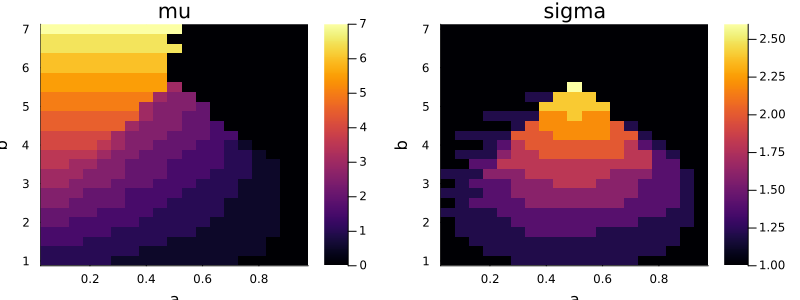

In [3]:
@time as1, bs1, c1, μs1, σs1, kl1, minimizer_coordinate1, minimizer_μ1, minimizer_σ1, minval1 = simKL(
        as = 0.05:0.05:0.95,
        bs = 1.0:0.25:7.0,
        c = 1.0,
        μs = -1.5:0.5:8.5,
        σs = 0.2:0.2:4.0,
)

p1 = heatmap(as1, bs1, minimizer_μ1', title="mu",    xlabel="a", ylabel="b", colorbar=true)
p2 = heatmap(as1, bs1, minimizer_σ1', title="sigma", xlabel="a", ylabel="b", colorbar=true)
plot(p1, p2, size=(800,300))

La = length(as) = 19
Lb = length(bs) = 25
Lμ = length(μs) = 21
Lσ = length(σs) = 20
(1,1)(1,2)(1,3)(1,4)(1,5)(1,6)(1,7)(1,8)(1,9)(1,10)(1,11)(1,12)(1,13)(1,14)(1,15)(1,16)(1,17)(1,18)(1,19)(1,20)(1,21)(1,22)(1,23)(1,24)(1,25)(2,1)(2,2)(2,3)(2,4)(2,5)(2,6)(2,7)(2,8)(2,9)(2,10)(2,11)(2,12)(2,13)(2,14)(2,15)(2,16)(2,17)(2,18)(2,19)(2,20)(2,21)(2,22)(2,23)(2,24)(2,25)(3,1)(3,2)(3,3)(3,4)(3,5)(3,6)(3,7)(3,8)(3,9)(3,10)(3,11)(3,12)(3,13)(3,14)(3,15)(3,16)(3,17)(3,18)(3,19)(3,20)(3,21)(3,22)(3,23)(3,24)(3,25)(4,1)(4,2)(4,3)(4,4)(4,5)(4,6)(4,7)(4,8)(4,9)(4,10)(4,11)(4,12)(4,13)(4,14)(4,15)(4,16)(4,17)(4,18)(4,19)(4,20)(4,21)(4,22)(4,23)(4,24)(4,25)(5,1)(5,2)(5,3)(5,4)(5,5)(5,6)(5,7)(5,8)(5,9)(5,10)(5,11)(5,12)(5,13)(5,14)(5,15)(5,16)(5,17)(5,18)(5,19)(5,20)(5,21)(5,22)(5,23)(5,24)(5,25)(6,1)(6,2)(6,3)(6,4)(6,5)(6,6)(6,7)(6,8)(6,9)(6,10)(6,11)(6,12)(6,13)(6,14)(6,15)(6,16)(6,17)(6,18)(6,19)(6,20)(6,21)(6,22)(6,23)(6,24)(6,25)(7,1)(7,2)(7,3)(7,4)(7,5)(7,6)(7,7)(7,8)(7,9)(7,10)(7,11)(7,12)(7,13)(

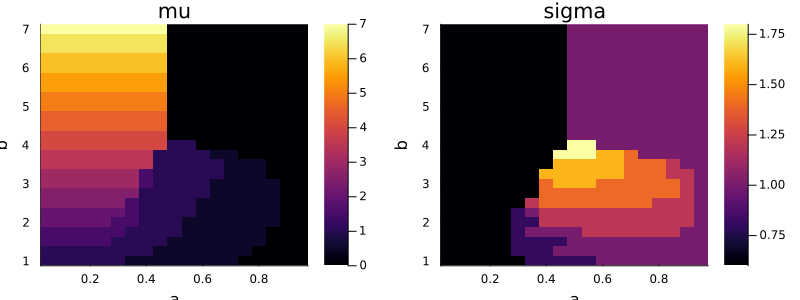

In [4]:
@time as2, bs2, c2, μs2, σs2, kl2, minimizer_coordinate2, minimizer_μ2, minimizer_σ2, minval2 = simKL(
        as = 0.05:0.05:0.95,
        bs = 1.0:0.25:7.0,
        c = 0.5,
        μs = -1.5:0.5:8.5,
        σs = 0.2:0.2:4.0,
)

p1 = heatmap(as2, bs2, minimizer_μ2', title="mu",    xlabel="a", ylabel="b", colorbar=true)
p2 = heatmap(as2, bs2, minimizer_σ2', title="sigma", xlabel="a", ylabel="b", colorbar=true)
plot(p1, p2, size=(800,300))

(as2[i], bs2[j]) = (0.5, 4.5)


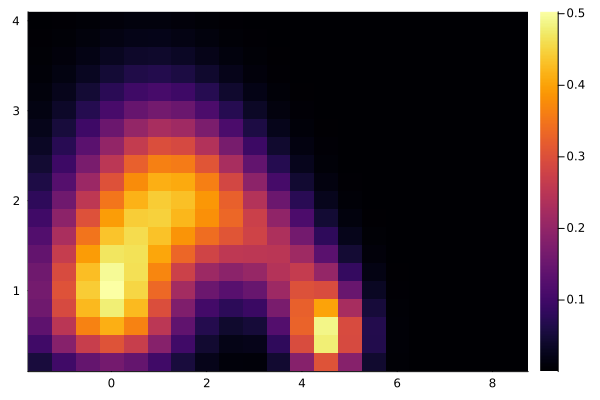

In [5]:
i, j = 10, 15
@show as2[i], bs2[j]
heatmap(μs2, σs2, exp.(-kl2[i,j,:,:]'), colorbar=true)

## 倍の細かさでプロット

4つのパラメーター座標の分割の細かさを倍にすると計算量は16倍に増える.

La = length(as) = 37
Lb = length(bs) = 49
Lμ = length(μs) = 41
Lσ = length(σs) = 40
(1,1)(1,2)(1,3)(1,4)(1,5)(1,6)(1,7)(1,8)(1,9)(1,10)(1,11)(1,12)(1,13)(1,14)(1,15)(1,16)(1,17)(1,18)(1,19)(1,20)(1,21)(1,22)(1,23)(1,24)(1,25)(1,26)(1,27)(1,28)(1,29)(1,30)(1,31)(1,32)(1,33)(1,34)(1,35)(1,36)(1,37)(1,38)(1,39)(1,40)(1,41)(1,42)(1,43)(1,44)(1,45)(1,46)(1,47)(1,48)(1,49)(2,1)(2,2)(2,3)(2,4)(2,5)(2,6)(2,7)(2,8)(2,9)(2,10)(2,11)(2,12)(2,13)(2,14)(2,15)(2,16)(2,17)(2,18)(2,19)(2,20)(2,21)(2,22)(2,23)(2,24)(2,25)(2,26)(2,27)(2,28)(2,29)(2,30)(2,31)(2,32)(2,33)(2,34)(2,35)(2,36)(2,37)(2,38)(2,39)(2,40)(2,41)(2,42)(2,43)(2,44)(2,45)(2,46)(2,47)(2,48)(2,49)(3,1)(3,2)(3,3)(3,4)(3,5)(3,6)(3,7)(3,8)(3,9)(3,10)(3,11)(3,12)(3,13)(3,14)(3,15)(3,16)(3,17)(3,18)(3,19)(3,20)(3,21)(3,22)(3,23)(3,24)(3,25)(3,26)(3,27)(3,28)(3,29)(3,30)(3,31)(3,32)(3,33)(3,34)(3,35)(3,36)(3,37)(3,38)(3,39)(3,40)(3,41)(3,42)(3,43)(3,44)(3,45)(3,46)(3,47)(3,48)(3,49)(4,1)(4,2)(4,3)(4,4)(4,5)(4,6)(4,7)(4,8)(4,9)(4,10)(4,11)(4,1

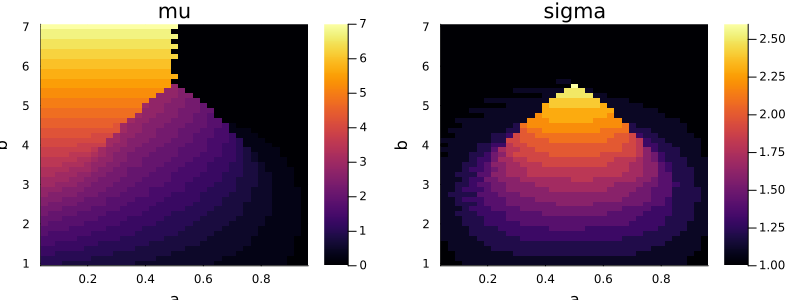

In [6]:
@time as3, bs3, c3, μs3, σs3, kl3, minimizer_coordinate3, minimizer_μ3, minimizer_σ3, minval3 = simKL(
        as = 0.05:0.025:0.95,
        bs = 1.0:0.125:7.0,
        c = 1.0,
        μs = -1.5:0.25:8.5,
        σs = 0.1:0.1:4.0,
)

p1 = heatmap(as3, bs3, minimizer_μ3', title="mu",    xlabel="a", ylabel="b", colorbar=true)
p2 = heatmap(as3, bs3, minimizer_σ3', title="sigma", xlabel="a", ylabel="b", colorbar=true)
plot(p1, p2, size=(800,300))

(as3[i], bs3[j]) = (0.525, 7.0)


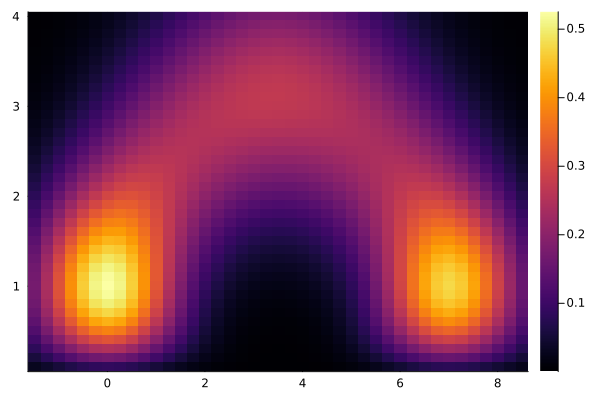

In [7]:
i, j = 20, 49
@show as3[i], bs3[j]
heatmap(μs3, σs3, exp.(-kl3[i,j,:,:]'), colorbar=true)

La = length(as) = 37
Lb = length(bs) = 49
Lμ = length(μs) = 41
Lσ = length(σs) = 40
(1,1)(1,2)(1,3)(1,4)(1,5)(1,6)(1,7)(1,8)(1,9)(1,10)(1,11)(1,12)(1,13)(1,14)(1,15)(1,16)(1,17)(1,18)(1,19)(1,20)(1,21)(1,22)(1,23)(1,24)(1,25)(1,26)(1,27)(1,28)(1,29)(1,30)(1,31)(1,32)(1,33)(1,34)(1,35)(1,36)(1,37)(1,38)(1,39)(1,40)(1,41)(1,42)(1,43)(1,44)(1,45)(1,46)(1,47)(1,48)(1,49)(2,1)(2,2)(2,3)(2,4)(2,5)(2,6)(2,7)(2,8)(2,9)(2,10)(2,11)(2,12)(2,13)(2,14)(2,15)(2,16)(2,17)(2,18)(2,19)(2,20)(2,21)(2,22)(2,23)(2,24)(2,25)(2,26)(2,27)(2,28)(2,29)(2,30)(2,31)(2,32)(2,33)(2,34)(2,35)(2,36)(2,37)(2,38)(2,39)(2,40)(2,41)(2,42)(2,43)(2,44)(2,45)(2,46)(2,47)(2,48)(2,49)(3,1)(3,2)(3,3)(3,4)(3,5)(3,6)(3,7)(3,8)(3,9)(3,10)(3,11)(3,12)(3,13)(3,14)(3,15)(3,16)(3,17)(3,18)(3,19)(3,20)(3,21)(3,22)(3,23)(3,24)(3,25)(3,26)(3,27)(3,28)(3,29)(3,30)(3,31)(3,32)(3,33)(3,34)(3,35)(3,36)(3,37)(3,38)(3,39)(3,40)(3,41)(3,42)(3,43)(3,44)(3,45)(3,46)(3,47)(3,48)(3,49)(4,1)(4,2)(4,3)(4,4)(4,5)(4,6)(4,7)(4,8)(4,9)(4,10)(4,11)(4,1

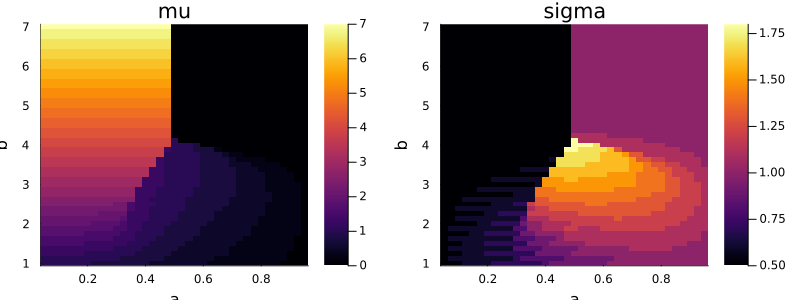

In [8]:
@time as4, bs4, c4, μs4, σs4, kl4, minimizer_coordinate4, minimizer_μ4, minimizer_σ4, minval4 = simKL(
        as = 0.05:0.025:0.95,
        bs = 1.0:0.125:7.0,
        c = 0.5,
        μs = -1.5:0.25:8.5,
        σs = 0.1:0.1:4.0,
)

p1 = heatmap(as4, bs4, minimizer_μ4', title="mu",    xlabel="a", ylabel="b", colorbar=true)
p2 = heatmap(as4, bs4, minimizer_σ4', title="sigma", xlabel="a", ylabel="b", colorbar=true)
plot(p1, p2, size=(800,300))

(as4[i], bs4[j]) = (0.475, 5.25)


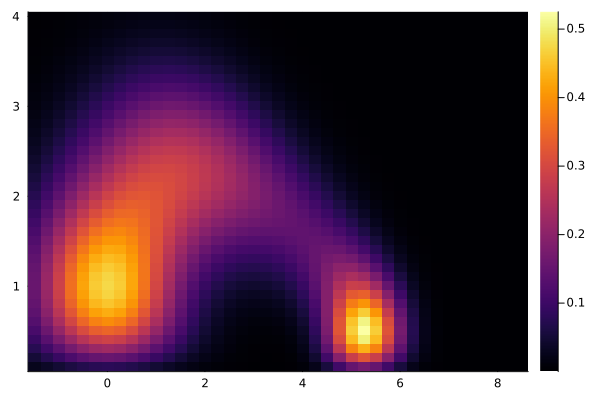

In [9]:
i, j = 18, 35
@show as4[i], bs4[j]
heatmap(μs4, σs4, exp.(-kl4[i,j,:,:]'), colorbar=true)

## データの保存

In [ ]:
# @autoadd using JLD2
# @autoadd using FileIO

In [ ]:
#=
data1 = Dict(
    "as1" => as1, 
    "bs1" => bs1, 
    "c1" => c1, 
    "μs1" => μs1, 
    "σs1" => σs1, 
    "σs1" => σs1, 
    "minimizer_coordinate1" => minimizer_coordinate1, 
    "minimizer_μ1" => minimizer_μ1, 
    "minimizer_σ1" => minimizer_σ1, 
    "minval1" => minval1 
)
save("data1.jld2", data1)
=#

In [ ]:
#=
data2 = Dict(
    "as2" => as2, 
    "bs2" => bs2, 
    "c2" => c2, 
    "μs2" => μs2, 
    "σs2" => σs2, 
    "σs2" => σs2, 
    "minimizer_coordinate2" => minimizer_coordinate2, 
    "minimizer_μ2" => minimizer_μ2, 
    "minimizer_σ2" => minimizer_σ2, 
    "minval2" => minval2 
)
save("data2.jld2", data2)
=#

In [ ]:
#=
data3 = Dict(
    "as3" => as3, 
    "bs3" => bs3, 
    "c3" => c3, 
    "μs3" => μs3, 
    "σs3" => σs3, 
    "σs3" => σs3, 
    "minimizer_coordinate3" => minimizer_coordinate3, 
    "minimizer_μ3" => minimizer_μ3, 
    "minimizer_σ3" => minimizer_σ3, 
    "minval3" => minval3 
)
save("data3.jld2", data3)
=#

In [ ]:
#=
data4 = Dict(
    "as4" => as4, 
    "bs4" => bs4, 
    "c4" => c4, 
    "μs4" => μs4, 
    "σs4" => σs4, 
    "σs4" => σs4, 
    "minimizer_coordinate4" => minimizer_coordinate4, 
    "minimizer_μ4" => minimizer_μ4, 
    "minimizer_σ4" => minimizer_σ4, 
    "minval4" => minval4 
)
save("data4.jld2", data4)
=#

## 解説

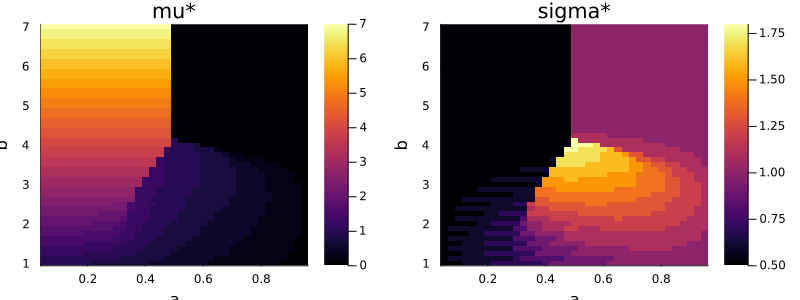

In [10]:
p1 = heatmap(as4, bs4, minimizer_μ4', title="mu*",    xlabel="a", ylabel="b", colorbar=true)
p2 = heatmap(as4, bs4, minimizer_σ4', title="sigma*", xlabel="a", ylabel="b", colorbar=true)
plot(p1, p2, size=(800,300))

すぐ上のプロットは本質的に上の方で示したプロットの再掲である. このプロットは以下で説明するような意味を持っている.

まず, 混合正規分布 $Q(a,b)$ の確率密度函数を次のように定義する:

$$
q(x|a,b) = a\,p_N(x|0,1) + (1-a)\,p_N(x|b,0.5)\quad (0\leqq a\leqq 1).
$$

ここで $p_N$ は正規分布の確率密度函数である:

$$
p_N(x|\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right).
$$

この確率密度函数を持つ確率分布を $N(\mu,\sigma)$ と書くことにする.

$b$ が十分大きいならば(実際の計算では $1\leqq b\leqq 7$ とした), 混合正規分布 $Q(a,b)$ の確率密度函数のグラフは左右に2つの山を持つ.  左の山は平均 $0$, 標準偏差 $1$ の標準正規分布の $a$ 倍であり, 右の山は平均 $b$, 標準偏差 $0.5$ の正規分布の $1-a$ 倍である.  右の山の方が幅が小さい.

上のプロットは以上のような設定のもとでKullback-Leibler情報量

$$
\mathrm{KL}\left(N(\mu,\sigma)||Q(a,b)\right) = 
\int_{-\infty}^\infty p_N(x|\mu,\sigma)\log\frac{p_N(x|\mu,\sigma)}{q(x|a,b)}\,dx
$$

を最小にする $(\mu,\sigma)=(\mu^*, \sigma^*)$ を近似的に計算した結果のプロットである. 

以下の解説では小さな誤差を無視し, 完全な正確さを無視する. 上のプロットを見ると, 以下のようになっていることがわかる.

(1) $a<0.5$ かつ $b\leqq 4$ または $b<4$ でかつ $a$ が十分小さいとき, $(\mu^*, \sigma^*)$ の値は $(b, 0.5)$ にほぼ等しくなっている. すなわち, そのとき, KL情報量最小化で求めた正規分布 $P^*=N(\mu^*,\sigma^*)$ は混合正規分布 $Q=Q(a,b)$ の右側の山のもとになった正規分布に一致する.

(2) $a>0.5$ かつ $b\leqq 4$ のとき, $(\mu^*, \sigma^*)$ の値は $(0,1)$ にほぼ等しくなっている. すなわち, そのとき, KL情報量最小化で求めた正規分布 $P^*=N(\mu^*,\sigma^*)$ は混合正規分布 $Q=Q(a,b)$ の左側の山のもとになった正規分布に一致する.

(3) 上のプロットの右下の領域で, $\mu*$ の値は $0$ と $b$ のあいだにあり, 標準偏差 $\sigma^*$ は $1$ より大きな値になっている.  すなわち, その領域では, KL情報量最小化で求めた正規分布 $P^*=N(\mu^*,\sigma^*)$ は混合正規分布 $Q=Q(a,b)$ の2つの山にまたがったなだらか正規分布になっている.

以下ではこのそれぞれについて典型的な場合についてプロットしてみよう.

In [11]:
@show as4, length(as4)
@show bs4, length(bs4)
@show μs4, length(μs4)
@show σs4, length(σs4);

(as4, length(as4)) = (0.05:0.025:0.95, 37)
(bs4, length(bs4)) = (1.0:0.125:7.0, 49)
(μs4, length(μs4)) = (-1.5:0.25:8.5, 41)
(σs4, length(σs4)) = (0.1:0.1:4.0, 40)


In [12]:
function plotPQ(i, j, as, bs, μs, σs, kl, minimizer_μ, minimizer_σ; xmin=-4, xmax=7)
    @show a, b = as[i], bs[j]
    @show μ, σ = minimizer_μ[i,j], minimizer_σ[i,j]

    Q = MixtureModel([Normal(0.0,1.0), Normal(b,0.5)], [a, 1-a])
    P = Normal(μ,σ)

    p1 = plot(title="exp(-KL(N(mu, sigma)||Q) for Q=Q($a, $b)", titlefontsize=10)
    heatmap!(p1, μs, σs, exp.(-kl[i,j,:,:]'))
    scatter!(p1, [μ], [σ], label="(mu*, sigma*)", legend=true)
    plot!(p1, xlabel="mu", ylabel="sigma")

    p2 = plot(title="P* = N(mu*, sigma*)", titlefontsize=10)
    plot!(p2, legend=:topleft)
    plot!(p2, x -> pdf(Q,x), xmin, xmax, label="Q")
    plot!(p2, x -> pdf(P,x), xmin, xmax, label="P*")
    plot!(p2, ylim=(0,0.85))
    
    xmin1, xmax1 = xmin+0.1*(xmax-xmin), xmax #-0.1*(xmax-xmin)
    
    p3 = plot(title="-logpdf(Q) and -logpdf(P*)", titlefontsize=8)
    plot!(p3, x->-logpdf(Q,x), xmin1, xmax1, label="Q")
    plot!(p3, x->-logpdf(P,x), xmin1, xmax1, label="P*")
    plot!(p3, legend=:topleft)

    p4 = plot(title="log(pdf(P*)/pdf(Q))", titlefontsize=8)
    plot!(p4, x->logpdf(P,x)-logpdf(Q,x), xmin1, xmax1)
    plot!(p4, x->0, xmin1, xmax1, color="gray", ls=:dot)

    p5 = plot(title="pdf(P) log(pdf(P*)/pdf(Q))", titlefontsize=8)
    plot!(p5, x->pdf(P,x)*(logpdf(P,x)-logpdf(Q,x)), xmin1, xmax1)
    plot!(p5, x->0, xmin1, xmax1, color="gray", ls=:dot)

    plot(p1, p2, p3, p4, p5, size=(800, 500), layout=@layout([grid(1,2); grid(1,3){0.4h}]))
end

plotPQ (generic function with 1 method)

**(1)の場合**

以下のプロットの $\mu^*$ は計算時のグリッドの区切り方が荒いせいで少し左にずれていると思う. 

(a, b) = (as[i], bs[j]) = (0.475, 4.125)
(μ, σ) = (minimizer_μ[i, j], minimizer_σ[i, j]) = (4.0, 0.5)


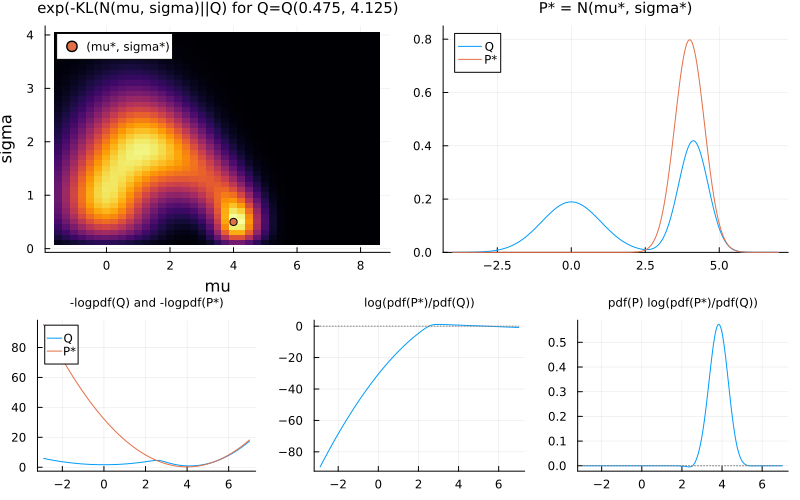

In [13]:
i, j = 18, 26
plotPQ(i, j, as4, bs4, μs4, σs4, kl4, minimizer_μ4, minimizer_σ4)

**(2)の場合**

(a, b) = (as[i], bs[j]) = (0.525, 4.125)
(μ, σ) = (minimizer_μ[i, j], minimizer_σ[i, j]) = (0.0, 1.1)


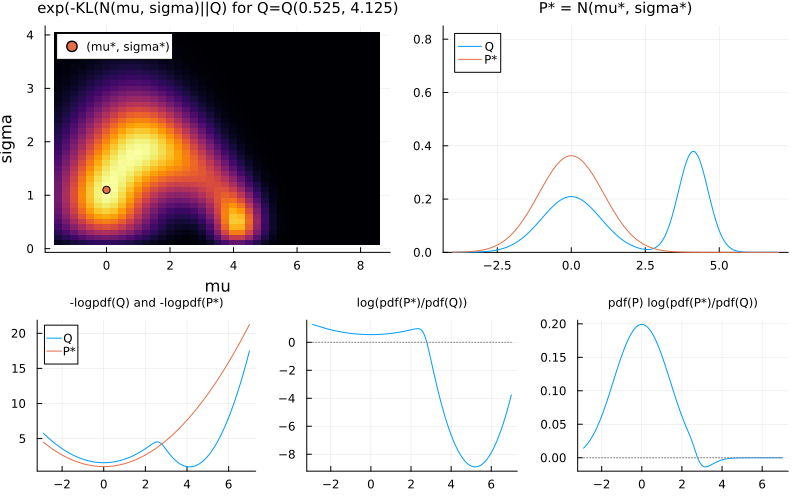

In [14]:
i, j = 20, 26
plotPQ(i, j, as4, bs4, μs4, σs4, kl4, minimizer_μ4, minimizer_σ4)

**(3)の場合**

(a, b) = (as[i], bs[j]) = (0.5, 4.0)
(μ, σ) = (minimizer_μ[i, j], minimizer_σ[i, j]) = (1.0, 1.8)


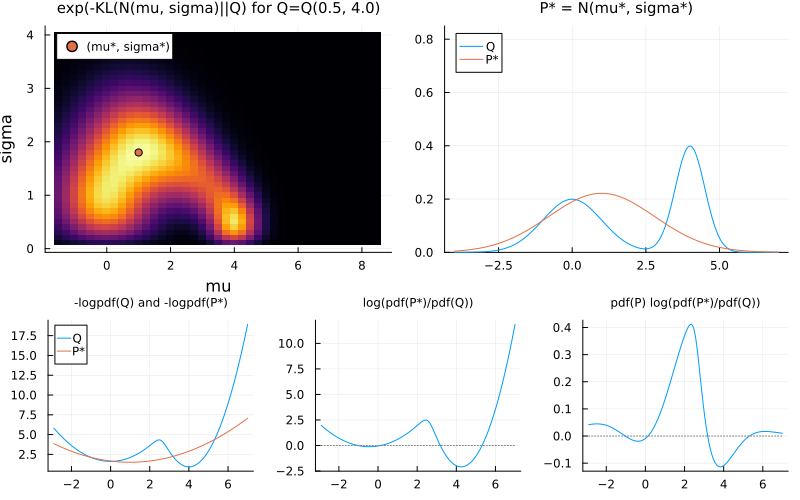

In [15]:
i, j = 19, 25
plotPQ(i, j, as4, bs4, μs4, σs4, kl4, minimizer_μ4, minimizer_σ4)

以上のプロット結果を見ればわかるように, 混合正規分布 $Q=Q(a,b)$ のパラメーター $(a,b)$ をほんの少し動かしただけで, KL情報量最小化で得た正規分布 $P^*=N(\mu^*,\sigma^*)$ は大きく不連続に変化することがある.